In [1]:

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path




Importing plotly failed. Interactive plots will not work.


Train: (156284, 1), Test: (1344, 1)
 The Average value is 1802067.0432098564


19:20:11 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing


Baseline Prophet: {'RMSE': np.float64(159720.36639261697), 'MAE': 129331.45246954667, 'MAPE': np.float64(7.422718347696066)}
Tuned Prophet:    {'RMSE': np.float64(168799.92181576535), 'MAE': 134286.66217844622, 'MAPE': np.float64(7.2855113554951565)}


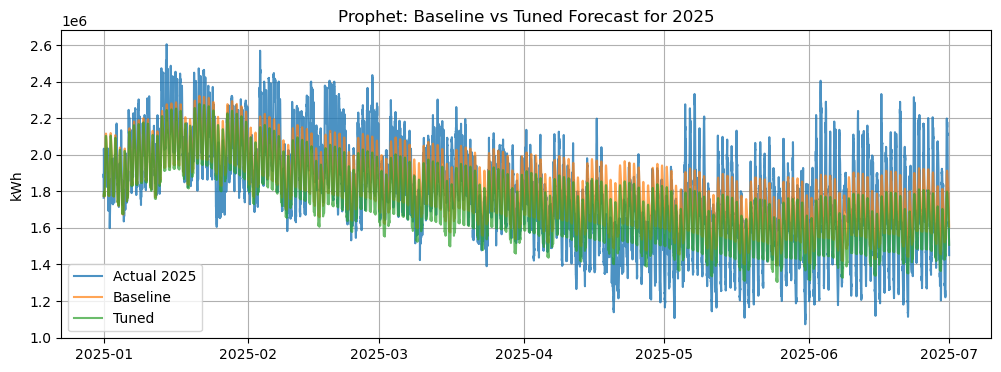

In [2]:
# train

df = pd.read_csv("../data/processed/electricity_total_consumption_15min.csv",
                 parse_dates=['datetime'], index_col='datetime')

# train/test split
horizon = 96 * 14  # 14 days of 15-min intervals
train = df.iloc[:-horizon]
test  = df.iloc[-horizon:]

print(f"Train: {train.shape}, Test: {test.shape}")


def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    mape = np.mean(abs((y_true - y_pred)/y_true) * 100)
    return {"RMSE" : rmse, "MAE" : mae, "MAPE" : mape}


print(f" The Average value is {df['total_consumption_kWh'].mean()}")


# —————————————
# Prophet.
# —————————————

# —————————————
# Data split by date (train: ≤2024-12-31, test: 2025-01-01 onward)
# —————————————
train = df.loc[: "2024-12-31 23:45"]
test  = df.loc["2025-01-01":]
horizon = len(test)

# —————————————
# Prepare for Prophet
# —————————————
prophet_df = train.reset_index().rename(columns={
    "datetime": "ds",
    "total_consumption_kWh": "y"
})

# —————————————
# Baseline Model.
# —————————————
m1 = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m1.fit(prophet_df)

# —————————————
# Forecast (Baseline).
# —————————————
future1  = m1.make_future_dataframe(periods=horizon, freq='15min')
forecast1 = m1.predict(future1)
y_pred1  = forecast1.set_index('ds')['yhat'][-horizon:]
metrics1 = evaluate(test['total_consumption_kWh'], y_pred1)

# —————————————
# Tuned Model.
# —————————————
m2 = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m2.fit(prophet_df)

# —————————————
# Forecast (Tuned).
# —————————————
future2  = m2.make_future_dataframe(periods=horizon, freq='15min')
forecast2 = m2.predict(future2)
y_pred2  = forecast2.set_index('ds')['yhat'][-horizon:]
metrics2 = evaluate(test['total_consumption_kWh'], y_pred2)

# —————————————
# Print & compare
# —————————————
print("Baseline Prophet:", metrics1)
print("Tuned Prophet:   ", metrics2)

plt.figure(figsize=(12,4))
plt.plot(test.index,       test['total_consumption_kWh'], label='Actual 2025', alpha=0.8)
plt.plot(test.index,       y_pred1,                        label='Baseline',    alpha=0.7)
plt.plot(test.index,       y_pred2,                        label='Tuned',       alpha=0.7)
plt.legend()
plt.title("Prophet: Baseline vs Tuned Forecast for 2025")
plt.ylabel("kWh")
plt.grid(True)
plt.show()
